In [1]:
import numpy as np
import pandas as pd
import requests 
import matplotlib.pyplot as plt
import seaborn as sns


import requests 
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
###Write function to query data by search terms:
def query_book_data_batch(url):
    """
    Download book per batch based on the url
    
    Arg: 
    url(string): the url to get book data
    
    Output: 
    Data Frame of bookd data per batch
    """
    
    #Query the data
    r = requests.get(url)
    json_data = r.json()
    items_list = json_data['items']
    
    #Construct the table
    title = []
    authors = []
    description = []
    date = []
    rating = []

    for i in range (0, len(items_list)): 
        title.append(dict(items_list[i]['volumeInfo'])['title'])
        for label, field in [(authors, 'authors'), (description, 'description'), (date, 'publishedDate'), (rating, 'averageRating')]:
            if field in dict(items_list[i]['volumeInfo']).keys():
                label.append(dict(items_list[i]['volumeInfo'])[field])  
            else:
                label.append('NA')

    #Zip data in to data frame
    df_book = pd.DataFrame(zip(title, authors, description, date, rating), columns = ['Title', 'Authors', 'Description', 'Date', 'Rating'])
    
    return df_book

In [18]:
###Write function to query tops 300 volumes:
def query_book_data(search_term, startIndex=0, maxResults=30):
    """
    Download book content on Google Books based on the search team, start index and number of results per query:
    
    Args:
    search_terms(strings): of search term
    startIndex(int): default = 0, the position to start query an interger from 1 to max length of the book list
    maxResults: default = 30, number of books to get in one request
    
    Returns: 
    Data Frame with 5 colums: Title, Authors, Description, Year, Avg Rating 
    """
    df_output = pd.DataFrame(columns=['Title', 'Authors', 'Description', 'Date', 'Rating'])
    for i in np.arange(0, 300, 30): 
        url = "https://www.googleapis.com/books/v1/volumes?q="+str(search_term)+"&startIndex="+str(i)+"&maxResults="+str(maxResults)+"&projection=lite&fields=items(volumeInfo)"
        df_output = pd.concat([df_output, query_book_data_batch(url)], axis=0)
    return df_output

In [21]:
###Write function to plot top terms in one domain
def domain_knowledge_explorer(search_term):
    """
    Plot top popular phrases that appear in the Google Book library based on search tearm
    
    Args: 
    search_term(str): search term
    
    Returns:
    Chart that shows top popular words
    """
    #Extract the description
    ref_lib = query_book_data(str(search_term))
    ref_lib_1 = ref_lib[['Description']].dropna(subset=['Description']).reset_index()
    doc = ref_lib_1['Description']
    
     #Count words frequency: n-word
    Countvec = CountVectorizer(max_features=50, ngram_range=(2,3), lowercase = True, stop_words = 'english')
    words_matrix = Countvec.fit_transform(doc)
    words_array = words_matrix.toarray()
    #Create dataframe of most popular n_word phrases:
    words_df = pd.DataFrame(words_array, columns = Countvec.get_feature_names())
    
    #Count words frequency: 1-word
    Countvec_mono = CountVectorizer(max_features=10, ngram_range=(1,1), lowercase = True, stop_words = 'english')
    words_matrix_mono = Countvec_mono.fit_transform(doc)
    words_array_mono = words_matrix_mono.toarray()
    #Create dataframe of most popular 1-word phrases:
    words_df_mono = pd.DataFrame(words_array_mono, columns = Countvec_mono.get_feature_names())
    
    #Create dataframe of most popular phrases:
    all_words_df = pd.concat([words_df_mono, words_df], axis = 1)
    top_words_predrop = pd.DataFrame(all_words_df.sum(axis=0).sort_values(ascending = False), columns = ['count'])
    top_words = top_words_predrop.drop(top_words_predrop.index[2:6], axis=0)
    
    #Plot
    fig, ax = plt.subplots(figsize=(16,8))
    sns.set_style('whitegrid')
    max_count=top_words['count'].max()
    ax.plot(top_words[:50]['count']/50, marker='o', c='black')
    ax.text(20, (max_count +5)/50, "Count of most popular word: "+str(max_count), c = 'black', fontsize=12)
    plt.xticks([])
    plt.yticks([])
    
  
    i=0
    for word in top_words[:50].index:
        ax.text(i, (top_words.loc[word]['count']+1)/50, word, rotation=45, c = (0.1, i/len(top_words), 0.5), fontsize=10)
        i = i+1

    plt.xlabel('Most popular words', fontsize=12)
    plt.ylabel('Scaled frequency', fontsize=12)
    plt.title('Most popular terms in '+str(search_term)+' domain', fontsize=14)

    plt.show()

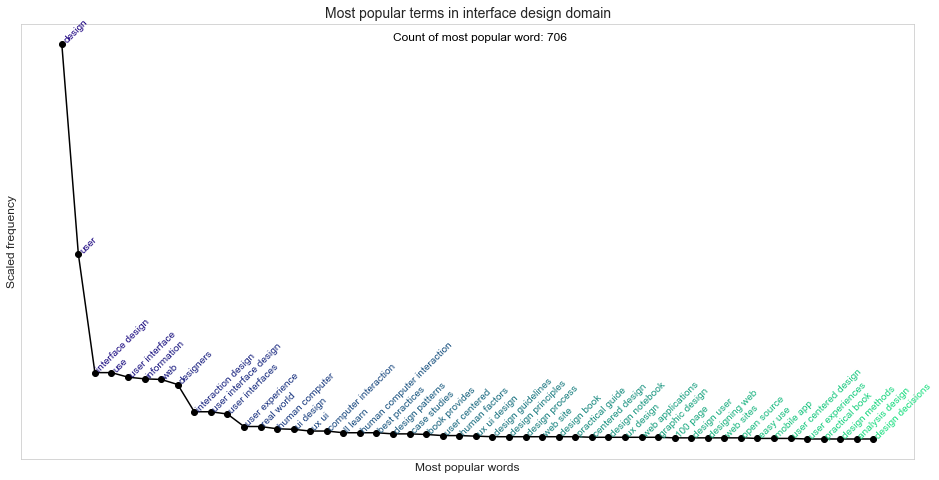

In [22]:
domain_knowledge_explorer('interface design')